In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import fsspec, os
import scipy as sp
import PIL
from PIL import Image
import random
import qkeras
from IPython.display import HTML
import ffmpeg
from matplotlib.animation import PillowWriter
import matplotlib.animation as animation

In [2]:
# import os
# import sys

# # The path shown in the warning
# scripts_path = r'C:\Users\javie\AppData\Roaming\Python\Python312\Scripts'

# # Add it to PATH if not already present
# if scripts_path not in os.environ["PATH"]:
#     os.environ["PATH"] += os.pathsep + scripts_path
#     sys.path.append(scripts_path)  # not always necessary, but safe

In [3]:
# !pip uninstall -y tensorflow
# !pip install tensorflow==2.18
# !pip install --upgrade tensorflow --user

In [4]:
#!conda install -c anaconda git
#!git clone https://github.com/google/qkeras

# To Do List

In [5]:
#Single Model Testing
    # replicate other models from william
    # test on different mode amplitudes
    # test on different outputs (mp, ao)
    # try cutting input data to 32x32 and redoing all of the above -DONE
#Genetic optimization
    # figure out how to update guess
    # figure out how to fill the options for a generation
    # figure out how to delete models to free memory


# Training Data (This will have to change once the data is reorganized)

In [6]:
shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,119661, 119662, 119663, 119665, 119666, 119667, 
             119669, 119670, 119671, 119673, 119675,119748, 119750, 119751, 119752, 119754, 119755, 119756, 119757, 119760, 119761, 
             119762, 119763, 119764, 119766, 119767, 119768, 119769]

file_path = 'Training/Input data/Shots/'
file_path_hbt = 'Training/pyhton_hbteplib_data/'
full_file_paths = []
frame_data_ratio = [1,1]
frame_data_ratio2 = [3,5]
for i in range(0,len(shot_list)):
    full_file_paths.append(file_path+str(shot_list[i])+'/CAM-26731/tiff/')
    

flat_training_data = []
training_data_2D = []
cut_training_data_2D = []
for i in range(0,len(shot_list)):
    flat_shot = []
    shot_2d = []
    cut_shot = []
    
    folder_path = full_file_paths[i]
    num_frames = sum(len(files) for _, _, files in os.walk(folder_path))
    for j in range(0,num_frames):
        if j > 999:
            file_frame_number = '0'+str(j)
        elif j > 99:
            file_frame_number = '00'+str(j)
        elif j > 9:
            file_frame_number = '000'+str(j)
        else:
            file_frame_number = '0000'+str(j)

        if j%frame_data_ratio[0]==0:
            im = Image.open(full_file_paths[i]+str(file_frame_number)+'.tiff')
            im = np.array(im)
            flat_im = im.reshape(-1) # flatten the 
            shot_2d.append(im)
            flat_shot.append(flat_im)
            cut_2d = im[:,48:-48]
            cut_shot.append(cut_2d)
        else:
            pass
    flat_training_data.append(flat_shot) # drope last 100 data points since they go beyond the gpu calculation
    training_data_2D.append(shot_2d)
    cut_training_data_2D.append(cut_shot)

flat_training_data = np.array(flat_training_data)
training_data_2D = np.array(training_data_2D)
cut_training_data_2D = np.array(cut_training_data_2D)
print(type(flat_training_data))
print(training_data_2D.shape)
print(cut_training_data_2D.shape)
print(training_data_2D[0][0])
#####Data Normalization##### TO DO


<class 'numpy.ndarray'>
(37, 800, 32, 128)
(37, 800, 32, 32)
[[3456 3296 3760 ... 3360 3328 3312]
 [3440 3472 3408 ... 3600 3328 3248]
 [3456 3200 3360 ... 3376 3680 3440]
 ...
 [3408 3440 3072 ... 3248 3184 3248]
 [3424 3360 3344 ... 3264 3392 3344]
 [3536 3360 3504 ... 3440 3344 3504]]


# Target Data

In [7]:
target_ma_path = 'Training/Target Data/Target Mode Amplitudes/'
target_time_path = 'Training/Target Data/Target Times/'
target_mp_path = 'Training/Target Data/Target Mode Phases/'
target_ao_path = 'Training/Target Data/Target Analog Outputs/'


target_ma_data = []
target_time_data = []
target_mp_data = []
target_ao_data = []

full_target_ma_paths = []
full_target_time_paths = []
full_target_mp_paths = []
full_target_ao_paths = []

start_index = 165 #index of first measurement at t>0 currently does not account for timing delay of the camera start trigger
mode_chan = 2 #index refering to the channel of mode amplitude of interest

for i in range(0,len(shot_list)):
    full_target_ma_paths.append(target_ma_path + str(shot_list[i])+'ma_store.npy')
    full_target_time_paths.append(target_time_path + str(shot_list[i])+'time_store.npy')
    full_target_mp_paths.append(target_mp_path + str(shot_list[i])+'mp_store.npy')
    full_target_ao_paths.append(target_ao_path + str(shot_list[i])+'ao_store.npy')
    
    ma_data = np.load(full_target_ma_paths[i])
    time_data = np.load(full_target_time_paths[i])
    mp_data = np.load(full_target_mp_paths[i])
    ao_data = np.load(full_target_ao_paths[i])
    
    ma_shot = []
    time_shot = []
    mp_shot = []
    ao_shot = []
    
    for j in range(start_index,len(ma_data)):
        if (j-start_index)%frame_data_ratio[1] == 0 :
            ma_shot.append([ma_data[j][mode_chan]]) # appends only the amplitude of the channel selected
            time_shot.append([time_data[j]])
            mp_shot.append([mp_data[j][mode_chan]]) # appends only the phase of the channel selected
            ao_shot.append([ao_data[j]])
        else:
            pass
    target_ma_data.append(ma_shot)
    target_time_data.append(time_shot)
    target_mp_data.append(mp_shot)
    target_ao_data.append(ao_shot)
target_ma_data = np.asarray(target_ma_data,dtype = float)
target_time_data = np.asarray(target_time_data,dtype = float)
target_mp_data = np.asarray(target_mp_data,dtype = float)
target_ao_data = np.asarray(target_ao_data,dtype = float)
print('ma shape ',target_ma_data.shape)
print('time shape',target_time_data.shape)
print('mp shape ',target_mp_data.shape)
print('ao shape ',target_ao_data.shape)

ma shape  (37, 834, 1)
time shape (37, 834, 1)
mp shape  (37, 834, 1)
ao shape  (37, 834, 1, 64)


In [8]:
def format_hbt_data(data,ratio,mode_num):
    frame_ratio = ratio[0]
    data = np.asarray(data,dtype = float)
    data = np.reshape(data[:,mode_num-1,:],(len(shot_list),5000,1))
    data = data[:,::frame_ratio,:]
    data = data[:,:800,:]
    return data

# pull data from the hbteplib folder
file_path_hbt = 'Training/python_hbteplib_data/'
hbt_ma_data = []
hbt_mp_data = []
hbt_time_data = []
hbt_framerate_ratio = [5,1]
for i in range(0,len(shot_list)):
    ma_list = []
    mp_list = []
    for j in range(1,5):
        ma_data = np.load(file_path_hbt+str(shot_list[i])+'m'+str(j)+'Amp.npy')
        mp_data = np.load(file_path_hbt+str(shot_list[i])+'m'+str(j)+'Phase.npy')
        ma_list.append(ma_data)
        mp_list.append(mp_data)
    
    hbt_ma_data.append(ma_list)
    hbt_mp_data.append(mp_list)
    time_data = np.load(file_path_hbt+str(shot_list[i])+'time.npy')
    hbt_time_data.append(time_data)

#print(type(hbt_time_data[0][0]))
#print(hbt_time)


hbt_ma1_data = format_hbt_data(hbt_ma_data,[5,1],1)
hbt_ma2_data = format_hbt_data(hbt_ma_data,[5,1],2)
hbt_ma3_data = format_hbt_data(hbt_ma_data,[5,1],3)
hbt_ma4_data = format_hbt_data(hbt_ma_data,[5,1],4)


hbt_mp1_data = format_hbt_data(hbt_mp_data,[5,1],1)
hbt_mp2_data = format_hbt_data(hbt_mp_data,[5,1],2)
hbt_mp3_data = format_hbt_data(hbt_mp_data,[5,1],3)
hbt_mp4_data = format_hbt_data(hbt_mp_data,[5,1],4)

hbt_time_data = np.asarray(hbt_time_data,dtype = float)
hbt_time_data = np.reshape(hbt_time_data,(37,5000))
hbt_time_data = hbt_time_data[:,::5]
hbt_time_data = hbt_time_data[:,:800]

print(hbt_ma1_data.shape)
print(hbt_mp1_data.shape)
print(hbt_time_data.shape)

(37, 800, 1)
(37, 800, 1)
(37, 800)


# Assign Labels

Training shape:  (28800, 32, 32) Target shape:  (28800, 1)
Testing shape:  (800, 32, 32) Testing label shape:  (800, 1)


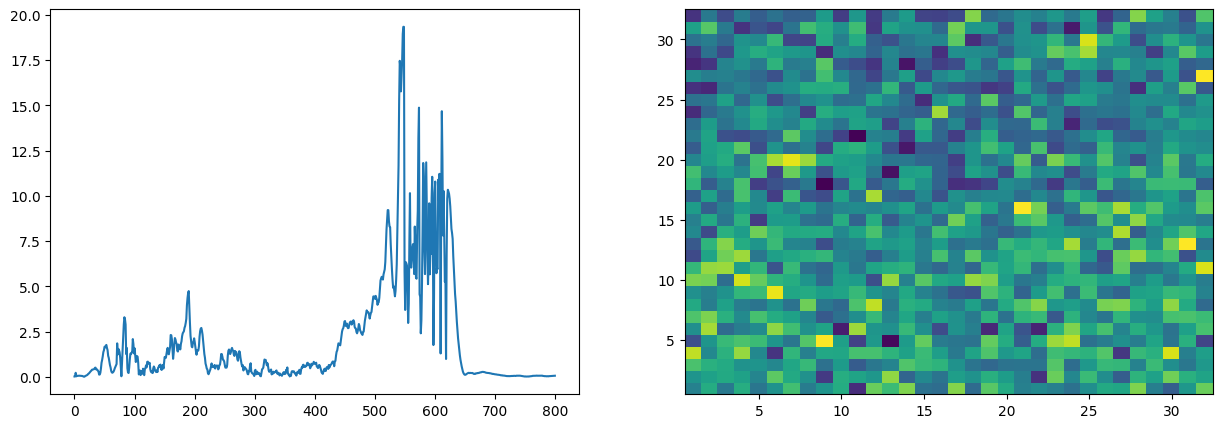

In [9]:
target_data = hbt_ma2_data
training_data = cut_training_data_2D
testing_shots = 1
camera_norm = 1 #placeholder
ma_norm = 1 #placeholder
mp_norm = 1 #placeholder
ao_norm = 1 #placeholder

input_norm_factor = camera_norm # set a normalization factor for the input data
output_norm_factor = ma_norm

# reshape the training data and labels to be one vector with each entry being a single frame/output
target_vector = []
training_vector = []
testing_inputs = []
testing_labels = []
tot_frames = 800 
for i in range(0,len(training_data)-testing_shots):
    for j in range(0,tot_frames):
        target_vector.append(target_data[i][j])
        training_vector.append(training_data[i][j])

for i in range(len(training_data)-testing_shots,len(training_data)):
    for j in range(0,tot_frames):
        testing_labels.append(target_data[i][j])
        testing_inputs.append(training_data[i][j])
        


#testing_imputs = training_vector[-testing_shots-1:-1] #last shot reserved for testing - not shuffled
#testing_labels = target_vector[-testing_shots-1:-1] #last shot resered for testing - not shuffled
#shuffle the data so as to remove ordering bias
random.seed(123)
zip_list = list(zip(target_vector,training_vector))
random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)
target_vector = np.asarray(target_vector,dtype=float)/output_norm_factor
training_vector = np.asarray(training_vector,dtype = float)/input_norm_factor

testing_labels = np.asarray(testing_labels,dtype=float)/output_norm_factor
testing_inputs = np.asarray(testing_inputs,dtype = float)/input_norm_factor


#testing_inputs = training_vector[-201:-1] # reserve the last 200 for testing (after shuffling)
#testing_labels = target_vector[-201:-1]

#training_vector = training_vector[0:-200]
#target_vector = target_vector[0:-200]


print('Training shape: ',training_vector.shape,'Target shape: ',target_vector.shape,)
print('Testing shape: ',testing_inputs.shape,'Testing label shape: ',testing_labels.shape)
fig, axes = plt.subplots(figsize=(15,5),ncols=2,nrows=1)
axes[0].plot(testing_labels)
#axes[1].plot(testing_labels)
xframe,yframe = np.meshgrid(np.linspace(1,32,32),np.linspace(1,32,32))
axes[1].pcolor(xframe,yframe,testing_inputs[600])

In [10]:
#from qkeras import *
#from qkeras import QDense, QActivation
#import tensorflow_model_optimization
#from tensorflow import model-optimization
#import tensorflow_model_optimization
#!pip install tensorflow-model-optimization
# import qkeras_Copy1 as qk
# will_model_q = tf.keras.models.Sequential()
# will_model_q.add(qkeras.qk.QDense(64,kernel_quantizer=quantized_bits(3),
#         bias_quantizer=quantized_bits(3)))
# will_model_q.add(qk.QDense(32,kernel_quantizer=quantized_bits(3),
#         bias_quantizer=quantized_bits(3)))

# Model

In [11]:
num_conv2d_layers = 3
num_dense_layers = 1


conv2d_neurons = [16,8,8]
conv2d_size = [(8,8),(4,4),(4,4)]

dense_layer_neurons = [32]
max_pooling_size = (4,4)
activation_func = 'relu'
loss_func = 'mean_squared_error'
optimizer_func = 'adam'

william_model = tf.keras.models.Sequential()

william_model.add(tf.keras.layers.InputLayer(shape=(32, 32, 1)))
for i in range(0,num_conv2d_layers):
    william_model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], 1, activation=activation_func))
    #william_model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, 1))
    
    

# Flatten the output for the fully connected layers
william_model.add(tf.keras.layers.Flatten())

for i in range(0,num_dense_layers):
    william_model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))


william_model.add(tf.keras.layers.Dense(1))

# Compile the model
william_model.compile(optimizer=optimizer_func, loss=loss_func)

# Summary of the model
william_model.summary()

model_dict = {"Number conv2d layers":num_conv2d_layers,"Number dense Layers":num_dense_layers,"conv2d neurons":conv2d_neurons,"conv2d size":conv2d_size,
             "dense layer neurons":dense_layer_neurons,"max pooling size":max_pooling_size,"activation function":activation_func,
             "loss function":loss_func,"optimizer function":optimizer_func}

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 25, 25, 16)          │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 8)           │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 8)           │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2888)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          92,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,609 (377.38 KB)

 Trainable params: 96,609 (377.38 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
Model = william_model # Sets the model you want to train/evaluate/plot

##### Training #####
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = Model.fit(training_vector, target_vector, 
                    #batch_size      = 4,
                    epochs          = 15,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 433105.7188 - val_loss: 14.3751
Epoch 2/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 14.9915 - val_loss: 14.3137
Epoch 3/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 14.6776 - val_loss: 14.2241
Epoch 4/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 13.8775 - val_loss: 14.0984
Epoch 5/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 14.0202 - val_loss: 13.9226
Epoch 6/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 13.7148 - val_loss: 13.6821
Epoch 7/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - loss: 13.8766 - val_loss: 13.3619
Epoch 8/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 12.9246 - val_loss: 12.9496
Epoch 9/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 13.3066 - val_loss: 12.4474
Epoch 10/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 12.3422 - val_loss: 11.8676
Epoch 11/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 12.1917 - val_loss: 11.2802
Epoc

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(800, 1)
1.8732239 0.052979671908918266


Text(0.5, 1.0, 'Normalized Testing Error')

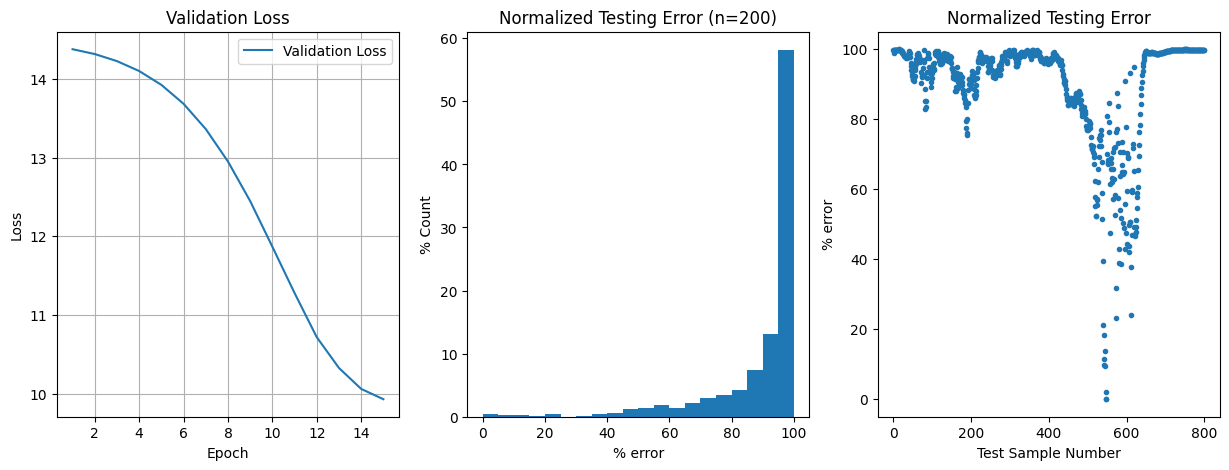

In [13]:
# Plot training & validation loss
test_num = 12
fig, axes = plt.subplots(figsize=(15,5),ncols=3,nrows=1)

#axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(range(1,16),history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Validation Loss')
axes[0].legend()
axes[0].grid(True)


#Testing Data Evaluation#
out =Model.predict(testing_inputs)
print(out.shape)
print(out[test_num][0],testing_labels[test_num][0])
prediction_errors = abs((testing_labels/max(testing_labels)-out/max(out)))*100 
weights = np.ones_like(prediction_errors) / len(prediction_errors) * 100 # used for the histogram plotting

axes[1].hist(prediction_errors,20,weights = weights)
axes[1].set_xlabel('% error')
axes[1].set_ylabel('% Count')
axes[1].set_title('Normalized Testing Error (n=200)')

axes[2].plot(prediction_errors,'.')
axes[2].set_xlabel('Test Sample Number')
axes[2].set_ylabel('% error')
axes[2].set_title('Normalized Testing Error')
#axes[2].set_ylim(0,100)

19.342438661327087 [1.8732239]


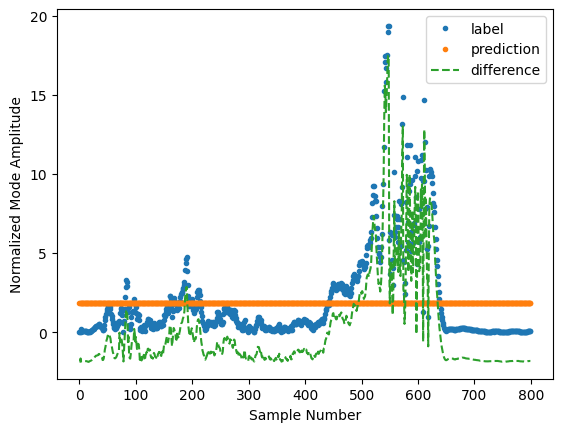

In [14]:
plt.plot(testing_labels[:],'.',label = 'label')
plt.plot(out[:],'.',label = 'prediction')
a = out[:]

plt.plot(testing_labels-(out),'--',label='difference')

plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.legend()
print(max(testing_labels[:,0]),max(out))
#print(testing_labels[:,0])


In [15]:
# fig, ax = plt.subplots()
# line1, = ax.plot([], [], color='blue')
# line2, = ax.plot([], [], color='blue')
# ax.set_xlim(hbt_time_data[0][0], hbt_time_data[0][300])
# ax.set_ylim(0, 25)

# def update_target(frame):
#     x = hbt_time_data[-1][:frame]
#     y1 = testing_labels[:frame]
#     y2 = out[:frame]
#     line1.set_data(x, y1)
#     line2.set_data(x, y2)
#     return line1, line2,
    
# #target_plot = ax.plot(hbt_time_data[0],testing_labels)
# ani2 = animation.FuncAnimation(fig,update_target, frames=300, interval=50, blit=False)
# ani2.save("animation2.gif",writer=PillowWriter(fps=20))
# Image(filename="animation2.gif")

# Optimization

In [16]:
'''
def gen_model(num_conv2d_layers = 3,num_dense_layers = 2,conv2d_neurons = [8,8,16],conv2d_size = [(4,4),(4,4),(4,4)],
              dense_layer_neurons = [42,64],max_pooling_size = (8,4),activation_func = 'relu',loss_func = 'mean_squared_error',
              optimizer_func = 'adam'):
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(shape=(32, 128, 1)))
    for i in range(0,num_conv2d_layers):
        model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], 1, activation=activation_func))
        model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, 1))
    
    

    # Flatten the output for the fully connected layers
    model.add(tf.keras.layers.Flatten())

    for i in range(0,num_dense_layers):
        model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))


    model.add(tf.keras.layers.Dense(1))

    # Compile the model
    model.compile(optimizer=optimizer_func, loss=loss_func)
    return model
    
def genetic_optimization(training_data,target_data,total_generations = 100,total_individuals = 10,
                         selection_percentage=0.1,mutation_rate = 0.1,max_parameters= False):
    full_param_list = []
    full_loss_list = []
    full_val_loss_list = []

    #initialize the original population
    num_conv2d_layers_options=[]
    num_dense_layers_options =[]
    conv2d_neurons_options=[]
    conv2d_size_options =[]
    dense_layer_neurons_options=[]
    max_pooling_size_options=[]
    activation_func_options=[]
    loss_func_options=[]
    optimizer_func_options=[]
    
    # train the original population
    generation_param_list = []
    for i in range(0,total_individuals):
        parameter_dict = {"Number conv2d layers":num_conv2d_layers_options[i],"Number dense Layers":num_dense_layers_options[i],
                      "conv2d neurons":conv2d_neurons_options[i],"conv2d size":conv2d_size_options[i],
                      "dense layer neurons":dense_layer_neurons_options[i],"max pooling size":max_pooling_size_options[i],
                      "activation function":activation_func_options[i],"loss function":loss_func_options[i],
                      "optimizer function":optimizer_func_options[i]}
        
        #generate a model
        model = gen_model(num_conv2d_layers = parameter_dict['number conv2d layers'],num_dense_layers =parameter_dict['number dense layers'] ,
                          conv2d_neurons = parameter_dict['conv2d neurons'],conv2d_size = parameter_dict['conv2d size'],
                          dense_layer_neurons = parameter_dict['dense_layer_neurons'],max_pooling_size = parameter_dict['max pooling size'],
                          activation_func = parameter_dict['activation function'],loss_func = parameter_dict['loss function'],
                          optimizer_func = parameter_dict['optimizer function'])
        #train a model
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        history = model.fit(training_data, target_data, batch_size= 4, epochs= 10, validation_split= 0.2, verbose= 0,callbacks= [early_stop])
        #metrics
        val_loss = history.history['val_loss']
        loss = history.history['val_loss']
        generation_param_list.append(param_dict)
    full_param_list.append(generation_param_list)

    
    for i in range(1,total_generations):
        generation_param_list = []
        generation_loss_list = []
        generation_val_loss_list = []

        
        # initialize the next generation
        num_conv2d_layers_options=[]
        num_dense_layers_options =[]
        conv2d_neurons_options=[]
        conv2d_size_options =[]
        dense_layer_neurons_options=[]
        max_pooling_size_options=[]
        activation_func_options=[]
        loss_func_options=[]
        optimizer_func_options=[]

        # train individuals
        for j in range(0,total_individuals):
            
            parameter_dict = {"Number conv2d layers":num_conv2d_layers_options[j],"Number dense Layers":num_dense_layers_options[j],
                          "conv2d neurons":conv2d_neurons_options[j],"conv2d size":conv2d_size_options[j],
                          "dense layer neurons":dense_layer_neurons_options[j],"max pooling size":max_pooling_size_options[j],
                          "activation function":activation_func_options[j],"loss function":loss_func_options[j],
                          "optimizer function":optimizer_func_options[j]}
            
            #generate an individual model
            model = gen_model(num_conv2d_layers = parameter_dict['number conv2d layers'],num_dense_layers =parameter_dict['number dense layers'] ,
                              conv2d_neurons = parameter_dict['conv2d neurons'],conv2d_size = parameter_dict['conv2d size'],
                              dense_layer_neurons = parameter_dict['dense_layer_neurons'],max_pooling_size = parameter_dict['max pooling size'],
                              activation_func = parameter_dict['activation function'],loss_func = parameter_dict['loss function'],
                              optimizer_func = parameter_dict['optimizer function'])
            #train a model
            early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
            history = model.fit(training_data, target_data, batch_size= 4, epochs= 10, validation_split= 0.2, verbose= 0,callbacks= [early_stop])
            #metrics
            val_loss = history.history['val_loss']
            loss = history.history['val_loss']
            generation_param_list.append(param_dict) # save the parameters of an individual generation for future use
            generation_loss_list.append(loss) # save the loss of an individual
            generation_val_loss_list.append(val_loss) # save the validation loss of an individual
        full_param_list.append(generation_param_list) # save the parameters of a generation
        full_loss_list.append(generation_loss_list)
        full_val_loss_list.append(generation_val_loss_list)
'''

'\ndef gen_model(num_conv2d_layers = 3,num_dense_layers = 2,conv2d_neurons = [8,8,16],conv2d_size = [(4,4),(4,4),(4,4)],\n              dense_layer_neurons = [42,64],max_pooling_size = (8,4),activation_func = \'relu\',loss_func = \'mean_squared_error\',\n              optimizer_func = \'adam\'):\n    \n    model = tf.keras.models.Sequential()\n\n    model.add(tf.keras.layers.InputLayer(shape=(32, 128, 1)))\n    for i in range(0,num_conv2d_layers):\n        model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], 1, activation=activation_func))\n        model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, 1))\n    \n    \n\n    # Flatten the output for the fully connected layers\n    model.add(tf.keras.layers.Flatten())\n\n    for i in range(0,num_dense_layers):\n        model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))\n\n\n    model.add(tf.keras.layers.Dense(1))\n\n    # Compile the model\n    model.compile(optimizer=optimizer_func, lo